In [9]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from imblearn.under_sampling import ClusterCentroids

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [2]:
df = pd.read_csv("data/creditcard.csv")

In [4]:
df_nofraud = df[df["Class"] == 0]
df_fraud = df[df["Class"] == 1]

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


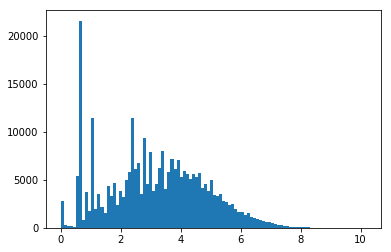

In [25]:
plt.hist(np.log(df["Amount"]+1), bins=100)
plt.show()

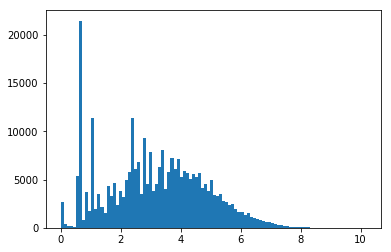

In [21]:
plt.hist(np.log(df_nofraud["Amount"]+1), bins=100)
plt.show()

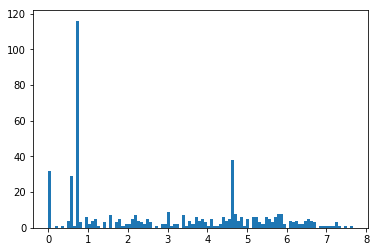

In [23]:
plt.hist(np.log(df_fraud["Amount"]+1), bins=100)
plt.show()

In [29]:
len(df[df["Amount"] < 2])

46990

In [30]:
len(df)

284807

In [88]:
def calcul_metrics(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    return (roc_auc_score(y_true, y_pred), auc(recall, precision))

def cacul_score(scores):
    print(" ROC auc : ", np.round(np.mean(scores["roc_auc"]), decimals=3), " (+/-", np.round(np.std(scores["roc_auc"]), decimals=2), ")")
    print(" P-R auc : ", np.round(np.mean(scores["pr_auc"]), decimals=3), " (+/-", np.round(np.std(scores["pr_auc"]), decimals=2), ")")
    print(" Time :", np.round(np.mean(scores["time"]), decimals=2), " sec")
    
    return (
        np.round(np.mean(scores["roc_auc"]), decimals=3),
        np.round(np.std(scores["roc_auc"]), decimals=2),
        np.round(np.mean(scores["pr_auc"]), decimals=3),
        np.round(np.std(scores["pr_auc"]), decimals=2),
        np.round(np.mean(scores["time"]), decimals=2)
    )

# Model - original

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn import svm
import xgboost as xgb
from sklearn.metrics import make_scorer
from tqdm import tqdm
import scikitplot as skplt

In [22]:
df = pd.read_csv("data/creditcard.csv")
y = df["Class"]
X = df.drop("Class", 1).drop("Time", 1)
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.fit_transform(X)

In [104]:
def run_model(name, model):
    skf=StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
    scores = {"time" : [], "roc_auc": [], "pr_auc" : []}
    print(" ---------- ", name, " ------- ")
    for train_index, test_index in tqdm(skf.split(X, y)):
        x_train, y_train = X[train_index], y[train_index]
        x_test, y_test = X[test_index], y[test_index]
        rus = RandomUnderSampler(random_state=0)
        X_res, y_res = rus.fit_resample(x_train, y_train)
        start_time = time.time()
        m = model
        m.fit(X_res, y_res)
        pred = m.predict(x_test)
        roc_auc, pr_auc = calcul_metrics(y_test, pred)
        scores["time"].append(time.time() - start_time)
        scores["roc_auc"].append(roc_auc)
        scores["pr_auc"].append(pr_auc)
    score_final = cacul_score(scores)
    np.save("scores/random_"+name, score_final)

In [100]:
# t = LogisticRegression(solver="lbfgs")
# run_model("test", t)

In [103]:
models = (
    (QuadraticDiscriminantAnalysis(), "LDA"),
    (MLPClassifier(hidden_layer_sizes=(100,)), "MLP"),
    (GaussianNB(), "Naive Bayes"),
    (xgb.XGBClassifier(n_estimators=50, n_jobs=-1), "XGBoost"),
    (RandomForestClassifier(max_depth=15, n_estimators=50, n_jobs=-1), "Random Forest"),
    (svm.LinearSVC(), "SVM"),
    (LogisticRegression(n_jobs=-1, solver="lbfgs"), "Logistic Regression")
)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

In [ ]:
cl = svm.SVC()
cl.fit(x_train, y_train)

C:\Users\tanni\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [19]:
pred = cl.predict(X_test)

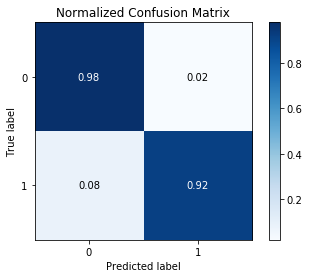

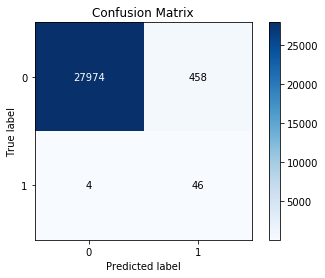

In [20]:
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=True)
skplt.metrics.plot_confusion_matrix(y_test, pred)

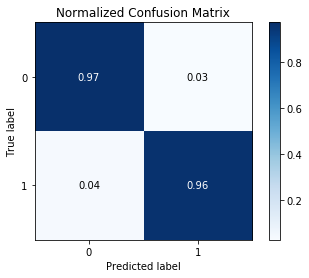

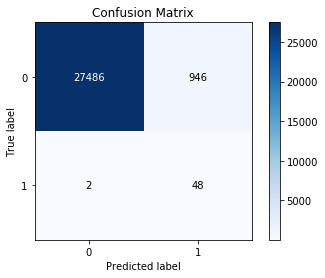

In [53]:
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=True)
skplt.metrics.plot_confusion_matrix(y_test, pred)

#### Logistic regression

In [21]:
t = LogisticRegression()
tm = cross_val_score(t, X, y, cv=10, scoring=make_scorer(roc_auc_score))
print("Accuracy: %0.2f (+/- %0.2f)" % (tm.mean(), tm.std() * 2))

Accuracy: 0.79 (+/- 0.19)


#### SVM

In [23]:
s = svm.LinearSVC()
cv = cross_val_score(s, X, y, cv=10, scoring=make_scorer(roc_auc_score))
print("Accuracy: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))

/home/yannis/.local/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.81 (+/- 0.24)


#### Random Forest

In [25]:
r = RandomForestClassifier(max_depth=15, n_estimators=50)
cv = cross_val_score(r, X, y, cv=10, scoring=make_scorer(roc_auc_score))
print("Accuracy: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))

Accuracy: 0.87 (+/- 0.13)


#### XGBClassifier

In [28]:
xgb_model = xgb.XGBClassifier(n_estimators=50)

In [29]:
cv = cross_val_score(xgb_model, X, y, cv=10, scoring=make_scorer(roc_auc_score))

In [30]:
print("Accuracy: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))

Accuracy: 0.88 (+/- 0.10)


#### GaussianNB

In [35]:
gb = GaussianNB()

In [36]:
cv = cross_val_score(gb, X, y, cv=10, scoring=make_scorer(roc_auc_score))

In [37]:
print("Accuracy: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))

Accuracy: 0.90 (+/- 0.10)


#### MLP

In [40]:
mp = MLPClassifier(hidden_layer_sizes=(100, 2))

In [41]:
cv = cross_val_score(mp, X, y, cv=10, scoring=make_scorer(roc_auc_score))

In [42]:
print("Accuracy: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))

Accuracy: 0.88 (+/- 0.10)


#### LinearDiscriminantAnalysis

In [43]:
lda = LinearDiscriminantAnalysis()

In [44]:
cv = cross_val_score(lda, X, y, cv=10, scoring=make_scorer(roc_auc_score))
print("Accuracy: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))

Accuracy: 0.87 (+/- 0.14)


# Model - Under Sampling 

In [27]:
from imblearn.under_sampling import RandomUnderSampler

In [47]:
rus = RandomUnderSampler(random_state=0)

In [48]:
X_rdmsamp, y_rdmsamp = rus.fit_resample(X, y)

In [52]:
##### Random under sampling

In [50]:
models = (
    LinearDiscriminantAnalysis(),
    MLPClassifier(hidden_layer_sizes=(100, 2)),
    GaussianNB(),
    xgb.XGBClassifier(n_estimators=50),
    RandomForestClassifier(max_depth=15, n_estimators=50),
    svm.LinearSVC(),
    LogisticRegression()  
)

In [51]:
for m in models :
    cv = cross_val_score(m, X_rdmsamp, y_rdmsamp, cv=10, scoring=make_scorer(roc_auc_score))
    print("Accuracy: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))

Accuracy: 0.86 (+/- 0.14)


/home/yannis/.local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: 0.92 (+/- 0.10)
Accuracy: 0.91 (+/- 0.08)
Accuracy: 0.93 (+/- 0.09)
Accuracy: 0.93 (+/- 0.09)
Accuracy: 0.92 (+/- 0.11)
Accuracy: 0.92 (+/- 0.10)


In [53]:
##### Kmeans under sampling

In [54]:
X_kmeanssampling = np.load("resultat/X_resampled.npy")
y_kmeanssampling = np.load("resultat/y_resampled.npy")

In [55]:
models = (
    LinearDiscriminantAnalysis(),
    MLPClassifier(hidden_layer_sizes=(100, 2)),
    GaussianNB(),
    xgb.XGBClassifier(n_estimators=50, n_jobs=-1),
    RandomForestClassifier(max_depth=15, n_estimators=50, n_jobs=-1),
    svm.LinearSVC(),
    LogisticRegression(n_jobs=-1)  
)

In [56]:
for m2 in models :
    cv = cross_val_score(m2, X_kmeanssampling, y_kmeanssampling, cv=10, scoring=make_scorer(roc_auc_score))
    print("Accuracy: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))

Accuracy: 0.90 (+/- 0.08)
Accuracy: 0.81 (+/- 0.40)
Accuracy: 0.90 (+/- 0.07)
Accuracy: 0.95 (+/- 0.05)
Accuracy: 0.95 (+/- 0.04)
Accuracy: 0.92 (+/- 0.09)
Accuracy: 0.92 (+/- 0.09)


In [8]:

# train, test = train_test_split(df, test_size=0.20, stratify=y)

In [14]:
scoring = {'rocauc': make_scorer(roc_auc_score)}

In [17]:
tm = cross_val_score(t, X, y, cv=10, scoring=make_scorer(roc_auc_score))

array([0.93943725, 0.67      , 0.92855384, 0.70408163, 0.69382479,
       0.75508445, 0.91831459, 0.75506687, 0.78571429, 0.75501411])

In [19]:
print("Accuracy: %0.2f (+/- %0.2f)" % (tm.mean(), tm.std() * 2))

Accuracy: 0.79 (+/- 0.19)


In [25]:
precision, recall, thresholds = precision_recall_curve([1,1,1,1,1,1,1,1,0], [0,1,1,1,1,1,1,1,1])
area = auc(recall, precision)
print("Area Under P-R Curve: ",area)

('Area Under P-R Curve: ', 0.9305555555555556)


In [24]:
roc_auc_score([1,1,1,1,1,1,1,1,0], [0,1,1,1,1,1,1,1,1])

0.4375

### Model - under sampling

In [4]:
y = df["Class"]
X = df.drop("Class", 1).drop("Time", 1)

scaler = preprocessing.StandardScaler()
scaler.fit(X)

train, test = train_test_split(df, test_size=0.20, stratify=y)

In [5]:
train["Class"].value_counts()

0    227451
1       394
Name: Class, dtype: int64

In [6]:
x_train_0 = train[train["Class"] == 0].drop("Class", axis=1).drop("Time", axis=1)
x_train_1 = train[train["Class"] == 1].drop("Class", axis=1).drop("Time", axis=1)
x_train_0 = scaler.transform(x_train_0)
x_train_1 = scaler.transform(x_train_1)

#### Grid Search 

In [6]:
def calcul_metrics(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    print(roc_auc_score(y_true, y_pred), " ", auc(recall, precision))

In [2]:
from sklearn.model_selection import GridSearchCV

In [4]:
df = pd.read_csv("data/creditcard.csv")
y = df["Class"]
X = df.drop("Class", 1).drop("Time", 1)
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.fit_transform(X)

In [13]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

In [4]:
param_grid = {
    'hidden_layer_sizes': [(50, ), (100,), (50, 2), (20,2)],
    'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'epsilon': [1e-3, 1e-7, 1e-8, 1e-9, 1e-8]
}

In [8]:
estimator = GridSearchCV(
        MLPClassifier(learning_rate='adaptive', learning_rate_init=1., early_stopping=True, shuffle=True),
        param_grid=param_grid, n_jobs=-1
)

In [ ]:
estimator.fit(X, y)

C:\Users\tanni\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [18]:
mp = MLPClassifier(hidden_layer_sizes=(100,2), alpha=0.00001)
mp.fit(X_tr, y_tr)
calcul_metrics(y_te, mp.predict(X_te))

0.9182266603884097   0.8368751383844153


In [19]:
mp = MLPClassifier(hidden_layer_sizes=(50,2), alpha=0.00001)
mp.fit(X_tr, y_tr)
calcul_metrics(y_te, mp.predict(X_te))

0.9131861699378682   0.8634145284109922


In [20]:
mp = MLPClassifier(hidden_layer_sizes=(50,2), alpha=0.0001)
mp.fit(X_tr, y_tr)
calcul_metrics(y_te, mp.predict(X_te))

0.9081456794873267   0.8961261434251252


In [21]:
mp = MLPClassifier(hidden_layer_sizes=(25,3), alpha=0.0001)
mp.fit(X_tr, y_tr)
calcul_metrics(y_te, mp.predict(X_te))

0.8876056225810527   0.796550363775389


In [22]:
mp = MLPClassifier(hidden_layer_sizes=(25,4), alpha=0.0001)
mp.fit(X_tr, y_tr)
calcul_metrics(y_te, mp.predict(X_te))

0.8877023445844292   0.8513628473840961


In [23]:
mp = MLPClassifier(hidden_layer_sizes=(50,3), alpha=0.0001)
mp.fit(X_tr, y_tr)
calcul_metrics(y_te, mp.predict(X_te))

0.9029820883052152   0.8520916387053336


In [24]:
mp = MLPClassifier(hidden_layer_sizes=(100,3), alpha=0.0001)
mp.fit(X_tr, y_tr)
calcul_metrics(y_te, mp.predict(X_te))

0.9232759437483491   0.8188391497183825


In [25]:
mp = MLPClassifier(hidden_layer_sizes=(10,5), alpha=0.0001)
mp.fit(X_tr, y_tr)
calcul_metrics(y_te, mp.predict(X_te))

0.9030084670334088   0.8679338846946384


In [27]:
mp = MLPClassifier(hidden_layer_sizes=(50,3), alpha=0.001)
mp.fit(X_tr, y_tr)
calcul_metrics(y_te, mp.predict(X_te))

0.9181826958414203   0.8165660438728243


In [28]:
mp = MLPClassifier(hidden_layer_sizes=(40,2), alpha=0.001)
mp.fit(X_tr, y_tr)
calcul_metrics(y_te, mp.predict(X_te))

0.9233902515705213   0.8746880110020263


In [33]:
mp = MLPClassifier(hidden_layer_sizes=(40,2), alpha=0.001, early_stopping=True)
mp.fit(X_tr, y_tr)
calcul_metrics(y_te, mp.predict(X_te))

0.872431393773041   0.8593350908004789


In [38]:
np.sum(y)/len(y)

0.001727485630620034

In [42]:
rf= RandomForestClassifier(max_depth=5, n_estimators=50, class_weight={0:0.99, 1:0.01})
rf.fit(X_tr, y_tr)
calcul_metrics(y_te, rf.predict(X_te))

0.5612156968865204   0.5235178405587751


In [43]:
rf= RandomForestClassifier(max_depth=10, n_estimators=50, class_weight={0:0.99, 1:0.01})
rf.fit(X_tr, y_tr)
calcul_metrics(y_te, rf.predict(X_te))

0.7856791140766943   0.7527496192114709


In [44]:
rf= RandomForestClassifier(max_depth=20, n_estimators=50, class_weight={0:0.99, 1:0.01})
rf.fit(X_tr, y_tr)
calcul_metrics(y_te, rf.predict(X_te))

0.9081017149403374   0.8680913803188735


In [47]:
rf= RandomForestClassifier(max_depth=25, n_estimators=100, class_weight={0:0.99, 1:0.01})
rf.fit(X_tr, y_tr)
calcul_metrics(y_te, rf.predict(X_te))

0.9030260528522045   0.8791316167995284


In [48]:
rf= RandomForestClassifier(max_depth=60, n_estimators=50, class_weight={0:0.99, 1:0.01})
rf.fit(X_tr, y_tr)
calcul_metrics(y_te, rf.predict(X_te))

0.9081193007591333   0.8789095006704624


In [ ]:
rf= RandomForestClassifier(max_depth=60, n_estimators=50, class_weight={0:0.99, 1:0.01})
rf.fit(X_tr, y_tr)
calcul_metrics(y_te, rf.predict(X_te))

In [54]:
xb = xgb.XGBClassifier(n_estimators=100, n_jobs=10, max_depth=50)
xb.fit(X_tr, y_tr)
calcul_metrics(y_te, xb.predict(X_te))

0.9081368865779289   0.8902489762197182


In [66]:
xb = xgb.XGBClassifier(n_estimators=200, n_jobs=10, max_depth=50)
xb.fit(X_tr, y_tr)
calcul_metrics(y_te, xb.predict(X_te))

0.9387051669288987   0.8963276520948681


In [65]:
xb = xgb.XGBClassifier(n_estimators=300, n_jobs=10, max_depth=100, scale_pos_weight=0.99)
xb.fit(X_tr, y_tr)
calcul_metrics(y_te, xb.predict(X_te))

0.9285010852962456   0.8852160566453695


In [64]:
xb = xgb.XGBClassifier(n_estimators=200, n_jobs=10, max_depth=100, importance_type="weight")
xb.fit(X_tr, y_tr)
calcul_metrics(y_te, xb.predict(X_te))

0.9387051669288987   0.8963276520948681


In [72]:
xb = xgb.XGBClassifier(n_estimators=500, n_jobs=10, max_depth=200)
xb.fit(X_tr, y_tr)
calcul_metrics(y_te, xb.predict(X_te))

0.9387051669288987   0.8963276520948681


In [73]:
xb = xgb.XGBClassifier(n_estimators=500, n_jobs=10, max_depth=200, scale_pos_weight=0.998)
xb.fit(X_tr, y_tr)
calcul_metrics(y_te, xb.predict(X_te))

0.9387051669288987   0.8963276520948681


In [74]:
xb = xgb.XGBClassifier(n_estimators=800, n_jobs=20, max_depth=200, scale_pos_weight=0.998)
xb.fit(X_tr, y_tr)
calcul_metrics(y_te, xb.predict(X_te))

0.9387139598382965   0.9012464349820792


In [76]:
xb = xgb.XGBClassifier(n_estimators=1200, n_jobs=20, max_depth=200, scale_pos_weight=0.998)
xb.fit(X_tr, y_tr)
calcul_metrics(y_te, xb.predict(X_te))

0.9387139598382965   0.9012464349820792


In [77]:
xb2 = xgb.XGBClassifier(n_estimators=800, n_jobs=20, max_depth=400, scale_pos_weight=0.998)
xb2.fit(X_tr, y_tr)
calcul_metrics(y_te, xb2.predict(X_te))

0.9387139598382965   0.9012464349820792


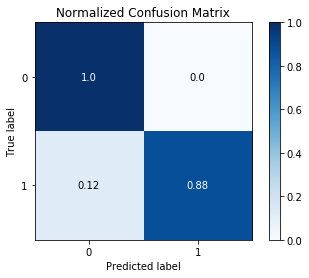

In [82]:
skplt.metrics.plot_confusion_matrix(y_te, xb2.predict(X_te), normalize=True)

In [12]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, stratify=y, random_state=11)
xb3 = xgb.XGBClassifier(n_estimators=800, n_jobs=20, max_depth=400, scale_pos_weight=0.998)
xb3.fit(X_tr, y_tr)
calcul_metrics(y_te, xb3.predict(X_te))

(0.9183409682105819, ' ', 0.9008607326221104)


In [13]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, stratify=y, random_state=12)
xb3 = xgb.XGBClassifier(n_estimators=800, n_jobs=20, max_depth=400, scale_pos_weight=0.998)
xb3.fit(X_tr, y_tr)
calcul_metrics(y_te, xb3.predict(X_te))

(0.9234430090269085, ' ', 0.906159194015171)


In [16]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, stratify=y, random_state=15)
xb3 = xgb.XGBClassifier(n_estimators=800, n_jobs=20, max_depth=400, scale_pos_weight=0.998)
xb3.fit(X_tr, y_tr)
calcul_metrics(y_te, xb3.predict(X_te))

(0.8978800474888886, ' ', 0.8464106013760152)


In [22]:
from sklearn.mixture import GaussianMixture

In [33]:
g = GaussianMixture(n_components=2, verbose=1)

In [34]:
g.fit(X_tr, y_tr)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

In [36]:
calcul_metrics(y_te, g.predict(X_te))

(0.5850652972218713, ' ', 0.4450378323488133)
